In [1]:
import os
import pandas as pd
import sklearn
import csv
import datetime
import numpy as np
# 可視化用
import japanize_matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

/Users/nobu/opt/anaconda3/envs/prophet_env/lib/python3.7/site-packages/japanize_matplotlib/__init__.py:13: MatplotlibDeprecationWarning: 
The createFontList function was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use FontManager.addfont instead.
  font_list = font_manager.createFontList(font_files)


## データの読み込み
DJIAデータ

ダウ・ジョーンズ・インデックスが算出するアメリカ合衆国の代表的な株価指数

https://fred.stlouisfed.org/series/DJIA/

In [2]:
df = pd.read_csv("../data/DJIA.csv")

In [3]:
df

,DATE,DJIA
0,2014-10-13,16321.07
1,2014-10-14,16315.19
2,2014-10-15,16141.74
3,2014-10-16,16117.24
4,2014-10-17,16380.41
...,...,...
1300,2019-10-07,26478.02
1301,2019-10-08,26164.04
1302,2019-10-09,26346.01
1303,2019-10-10,26496.67


In [4]:
df.dtypes

DATE    object
DJIA    object
dtype: object

## データのクリーニング

In [5]:
df["DJIA"] = df["DJIA"].replace(".", None)

In [6]:
df["DJIA"] = df["DJIA"].astype(np.float64)

In [7]:
df["DJIA"]

0       16321.07
1       16315.19
2       16141.74
3       16117.24
4       16380.41
          ...   
1300    26478.02
1301    26164.04
1302    26346.01
1303    26496.67
1304    26816.59
Name: DJIA, Length: 1305, dtype: float64

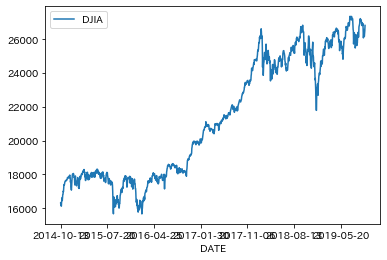

In [8]:
df.plot(x="DATE", y="DJIA")

In [9]:
df.dtypes

DATE     object
DJIA    float64
dtype: object

In [10]:
df["DATE"] = pd.to_datetime(df["DATE"])
df["DATE"]

0      2014-10-13
1      2014-10-14
2      2014-10-15
3      2014-10-16
4      2014-10-17
          ...    
1300   2019-10-07
1301   2019-10-08
1302   2019-10-09
1303   2019-10-10
1304   2019-10-11
Name: DATE, Length: 1305, dtype: datetime64[ns]

In [11]:
max(df["DATE"]), min(df["DATE"])

(Timestamp('2019-10-11 00:00:00'), Timestamp('2014-10-13 00:00:00'))

## Prophetによる時系列分析
状態空間モデル、ARIMAといった、統計モデルを扱うには、統計に関する知識が一定以上必要となります。
今回の講義では、実運用で活用させる、という意味でProphetを採用しました。

* 公式github
https://github.com/facebook/prophet

### Prophetの仕組み

$$
y(t) = g(t) + s(t) + h(t) + e(t)
$$

* y(t): 予測値
* g(t): growth, 季節性のない成長度合いを表現
* s(t): seasonality: weekly, yearlyの季節性を表現
* h(t): holiday: 休日の影響
* e(t): error: 誤差を表現

## Prophetを実装してみよう

In [12]:
from fbprophet import Prophet

Importing plotly failed. Interactive plots will not work.


In [13]:
# time変数は"ds"
# 目的変数は"y"

In [14]:
df["ds"] = df["DATE"]
df["y"]   = df["DJIA"]


In [15]:
df_train = df[df["DATE"] <= "2019-7-31"]
df_test    = df[(df["DATE"] >= "2019-8-1")]

In [16]:
train_size = len(df_train)
test_size = len(df_test)
train_size, test_size

(1253, 52)

In [17]:
m = Prophet()
m.fit(df[:train_size])

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [18]:
future = m.make_future_dataframe(periods=30, freq="d")
future

,ds
0,2014-10-13
1,2014-10-14
2,2014-10-15
3,2014-10-16
4,2014-10-17
...,...
1278,2019-08-26
1279,2019-08-27
1280,2019-08-28
1281,2019-08-29


In [19]:
future['day'] = future['ds'].dt.weekday
# Predict
forecast = m.predict(future)

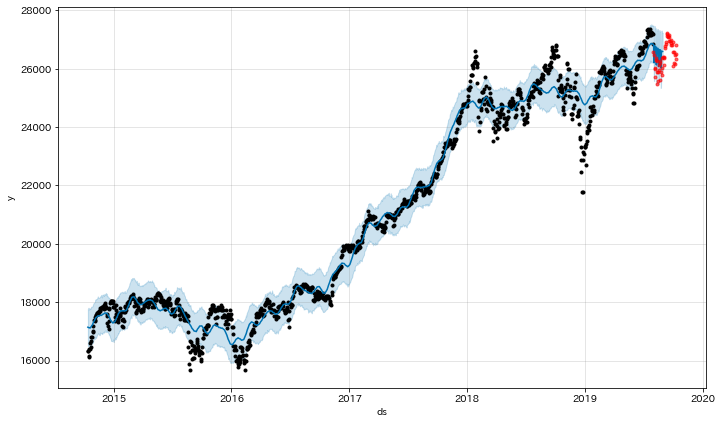

In [20]:
m.plot(forecast)
plt.plot(df[train_size: train_size+test_size].ds, df[train_size:train_size+test_size].y, ".", color="red", alpha=0.6)

* hyper parameter tuningなしで、かなり高精度な時系列予測が可能
* 異常値検知にも応用可能

## 異常検知プログラムを作成してみる

In [21]:
forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2014-10-13,17025.236696,16512.142354,17777.227681,17025.236696,17025.236696,118.598220,118.598220,118.598220,162.024817,162.024817,162.024817,-43.426597,-43.426597,-43.426597,0.0,0.0,0.0,17143.834916
1,2014-10-14,17035.701847,16488.247895,17749.119233,17035.701847,17035.701847,98.345865,98.345865,98.345865,163.991333,163.991333,163.991333,-65.645468,-65.645468,-65.645468,0.0,0.0,0.0,17134.047712
2,2014-10-15,17046.166997,16507.464910,17811.545741,17046.166997,17046.166997,85.436980,85.436980,85.436980,171.146886,171.146886,171.146886,-85.709906,-85.709906,-85.709906,0.0,0.0,0.0,17131.603977
3,2014-10-16,17056.632147,16522.339094,17779.249815,17056.632147,17056.632147,72.973640,72.973640,72.973640,176.301230,176.301230,176.301230,-103.327591,-103.327591,-103.327591,0.0,0.0,0.0,17129.605787
4,2014-10-17,17067.097298,16513.726848,17746.769342,17067.097298,17067.097298,59.480788,59.480788,59.480788,177.742795,177.742795,177.742795,-118.262008,-118.262008,-118.262008,0.0,0.0,0.0,17126.578085
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1278,2019-08-26,26190.099136,25931.754000,27247.251779,26167.576012,26205.077949,416.182665,416.182665,416.182665,162.024817,162.024817,162.024817,254.157847,254.157847,254.157847,0.0,0.0,0.0,26606.281801
1279,2019-08-27,26193.899258,25996.946124,27311.912121,26167.699332,26211.566409,406.648214,406.648214,406.648214,163.991333,163.991333,163.991333,242.656882,242.656882,242.656882,0.0,0.0,0.0,26600.547472
1280,2019-08-28,26197.699379,25981.195717,27261.973763,26167.717668,26217.350387,402.384690,402.384690,402.384690,171.146886,171.146886,171.146886,231.237804,231.237804,231.237804,0.0,0.0,0.0,26600.084069
1281,2019-08-29,26201.499500,25920.337200,27227.165688,26164.615554,26223.187350,396.327356,396.327356,396.327356,176.301230,176.301230,176.301230,220.026125,220.026125,220.026125,0.0,0.0,0.0,26597.826856


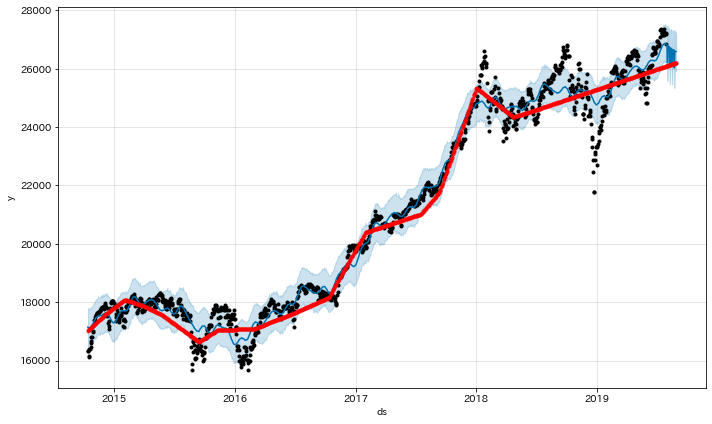

In [22]:
m.plot(forecast)
plt.plot(forecast.ds, forecast.trend, ".", color="red", alpha=0.6)

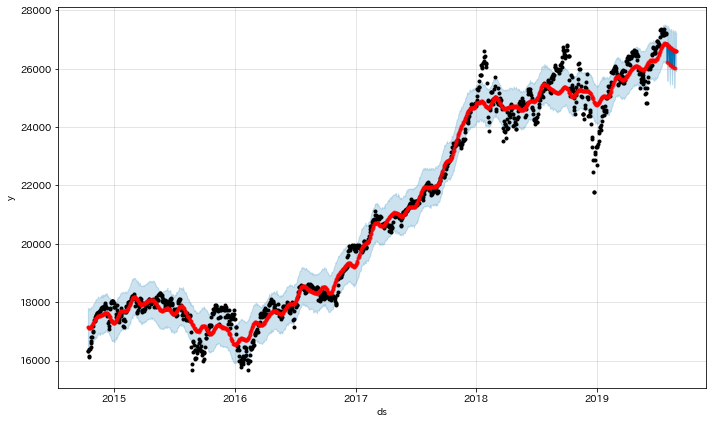

In [23]:
m.plot(forecast)
plt.plot(forecast.ds, forecast.yhat, ".", color="red", alpha=0.6)

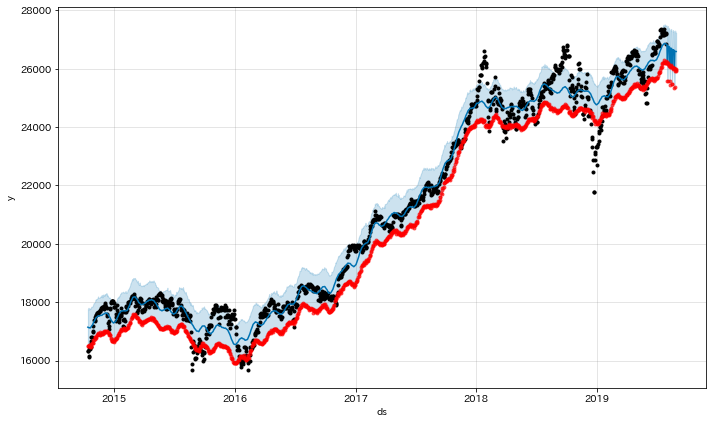

In [24]:
m.plot(forecast)
plt.plot(forecast.ds, forecast.yhat_lower, ".", color="red", alpha=0.6)

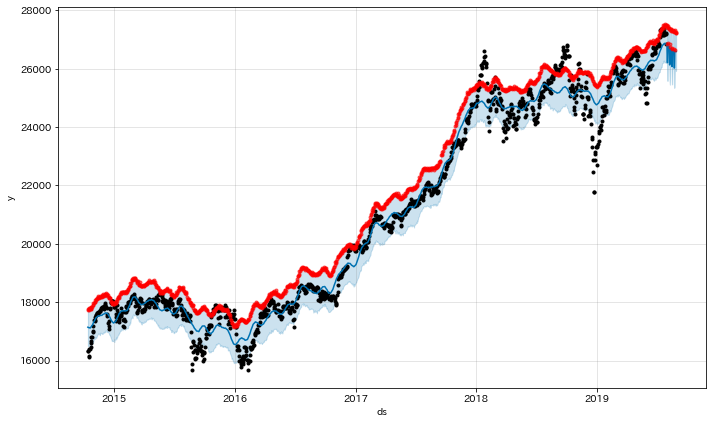

In [25]:
m.plot(forecast)
plt.plot(forecast.ds, forecast.yhat_upper, ".", color="red", alpha=0.6)

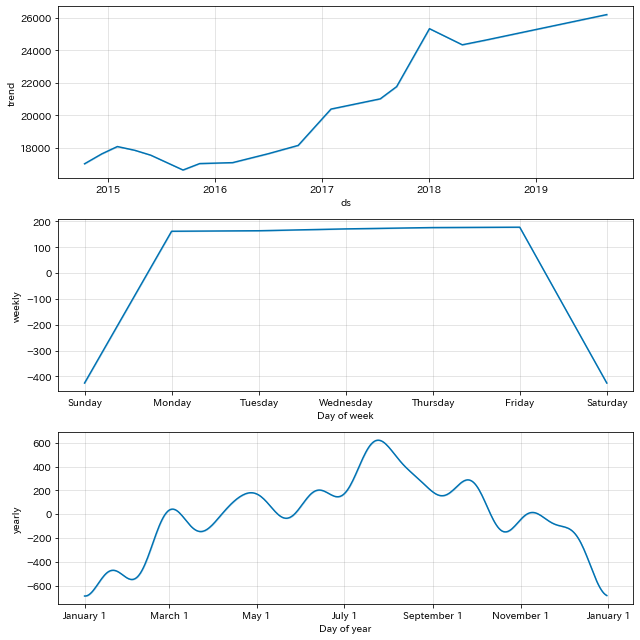

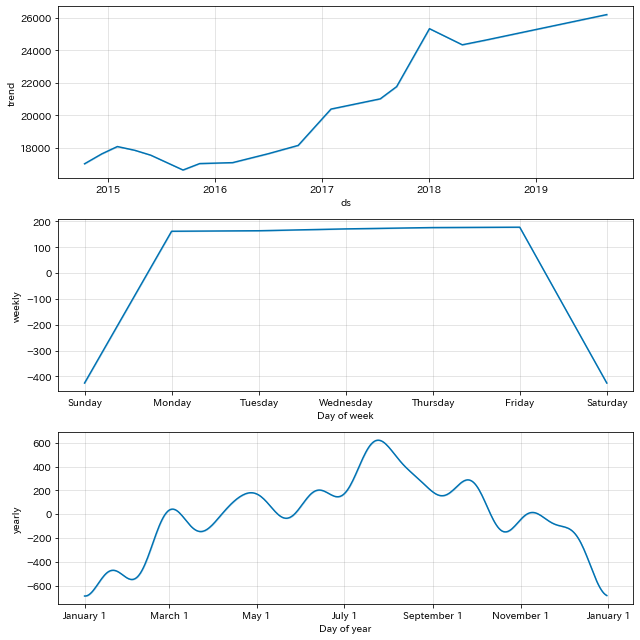

In [26]:
m.plot_components(forecast)

## 作るもの
* 前日までのデータで学習
* 当日の予測値(yhat)が、yhat_lowerを下回る、もしくはyhat_upperを上回る場合に異常値検知を実施するプログラム

In [27]:
today = datetime.date(2019, 10, 11)
df[df["DATE"] < today]

TypeError: Invalid comparison between dtype=datetime64[ns] and date

In [31]:
"""
1. 過去データで学習
2. 今日の平均株価指標を予測
3. y_upperを超えているか or y_lowerを下回っているか
"""

'\n1. 過去データで学習\n2. 今日の平均株価指標を予測\n3. y_upperを超えているか or y_lowerを下回っているか\n'

In [32]:
def fit_past_data(today):
    df_train = df[df["DATE"] < today]
    train_size = len(df_train)
    m = Prophet(daily_seasonality=True)
    m.fit(df[:train_size])
    return m

def predict(m, today):
    today_df = pd.DataFrame([])
    today_df["ds"] = [today]
    return m.predict(today_df)

def anomaly_detection(y_test, y_upper, y_lower):
    return (y_test > y_upper) | (y_test < y_lower)


In [33]:
anomaly_data = []
for date in df[df["DATE"] >= "2019-08-11"]["DATE"].values:
    m = fit_past_data(date)
    y_pred = predict(m, date)
    #上限
    y_upper = y_pred["yhat_upper"].values[0]
    #下限
    y_lower = y_pred["yhat_lower"].values[0]
    # 正解
    y_test = df[df["DATE"] == date]["y"].values[0]
    anomaly = anomaly_detection(y_test, y_upper, y_lower)
    
    anomaly_data.append(
        [date, anomaly]
    )
    print(date, anomaly)

2019-08-12T00:00:00.000000000 True
2019-08-13T00:00:00.000000000 False
2019-08-14T00:00:00.000000000 True
2019-08-15T00:00:00.000000000 True
2019-08-16T00:00:00.000000000 False
2019-08-19T00:00:00.000000000 False
2019-08-20T00:00:00.000000000 False
2019-08-21T00:00:00.000000000 False
2019-08-22T00:00:00.000000000 False
2019-08-23T00:00:00.000000000 True
2019-08-26T00:00:00.000000000 False
2019-08-27T00:00:00.000000000 False
2019-08-28T00:00:00.000000000 False
2019-08-29T00:00:00.000000000 False
2019-08-30T00:00:00.000000000 False
2019-09-02T00:00:00.000000000 False
2019-09-03T00:00:00.000000000 False
2019-09-04T00:00:00.000000000 False
2019-09-05T00:00:00.000000000 False
2019-09-06T00:00:00.000000000 False
2019-09-09T00:00:00.000000000 False
2019-09-10T00:00:00.000000000 False
2019-09-11T00:00:00.000000000 True
2019-09-12T00:00:00.000000000 True
2019-09-13T00:00:00.000000000 True
2019-09-16T00:00:00.000000000 False
2019-09-17T00:00:00.000000000 False
2019-09-18T00:00:00.000000000 False

In [34]:
## 異常検知を可視化

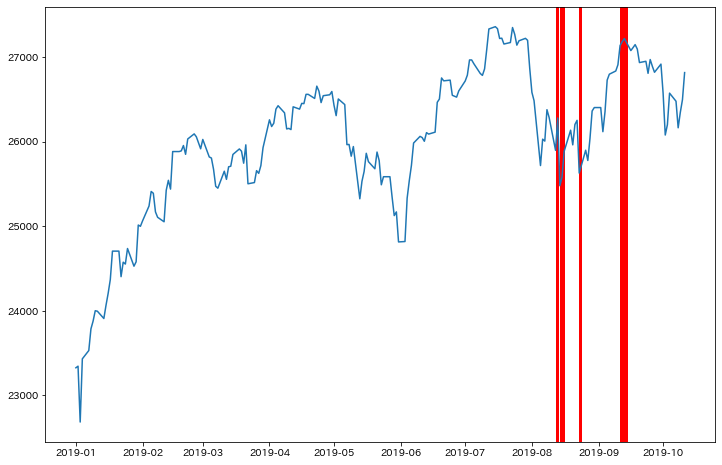

In [35]:
fig = plt.figure(figsize = (12, 8))
ax = fig.add_subplot(111)
plt.plot(df[df.ds >= "2019-01-01"].ds, df[df.ds >= "2019-01-01"].y)
for v in anomaly_data:
    if v[1]:
        ax.axvspan(v[0], v[0] + np.timedelta64(1, 'D'), color="red")#v[0]: date